## RNN architechture

In [62]:
%matplotlib inline
from gensim import corpora, models, similarities
from gensim import corpora
from gensim.models import word2vec
import gensim
import pandas as pd
import numpy as np
import os
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt

In [77]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
os.chdir('/Users/xiaodiu/Documents/github/JudgeSentences/train/')
from train_ngrams import textfeature

In [5]:
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.layers import Lambda
from keras import initializations
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
import pickle
from nltk import tokenize
import tensorflow as tf

### Data prepare

In [57]:
Holger = pd.read_excel('../rawdata/Holger_matched_USSC_TRAC2.xls',index_col=0,quotechar='"')
Holger = Holger.dropna()
Holger.head(1)

,usscidn,district,judgeid,sentyr,normed_sentence,trial,monrace,monsex,newcit,newrace,...,life,death,govdeparture,anyprison,judge_instate_ba,malejudge,judge_instate_birth,judge_local,judge_yearsonbench,crime
2,643856,Colorado,"MILLER, WALKER D.",2002,1.0,0.0,1.0,0.0,1.0,3,...,0,0,0.0,1,0.0,1.0,1.0,0.0,6.0,drug - trafficking


In [58]:
Holger = pd.get_dummies(Holger, columns=['monrace','newcit','newrace','neweduc','crime'], 
                               prefix=['monrace','newcit','newrace','newedu','crime'])

### baseline 

In [81]:
index = np.random.permutation(Holger.index)
train_data = Holger.loc[index[:Holger.shape[0]*0.8]]
test_data  = Holger.loc[index[Holger.shape[0]*0.8:]]

train_X = Holger.drop(['usscidn','district','judgeid','sentyr','normed_sentence'],axis=1).loc[index[:Holger.shape[0]*0.8]]
train_y = Holger.normed_sentence.loc[index[:Holger.shape[0]*0.8]]
test_x  = Holger.drop(['usscidn','district','judgeid','sentyr','normed_sentence'],axis=1).loc[index[Holger.shape[0]*0.8:]]
test_y  = Holger.normed_sentence.loc[index[Holger.shape[0]*0.8:]]

In [84]:
outlier = test_y.index[test_y < 10]
test_y = test_y[outlier]
test_x = test_x.loc[outlier,:]

In [72]:
ols = linear_model.LinearRegression()
ols.fit(train_X,train_y)
acc_test = np.mean((ols.predict(test_x) - test_y) ** 2)
acc_test

0.23109303813788046

In [75]:
rls = RandomForestRegressor()
rls.fit(train_X, train_y)
acc_test = np.mean((rls.predict(test_x) - test_y) ** 2)
acc_test

0.1872721832741586

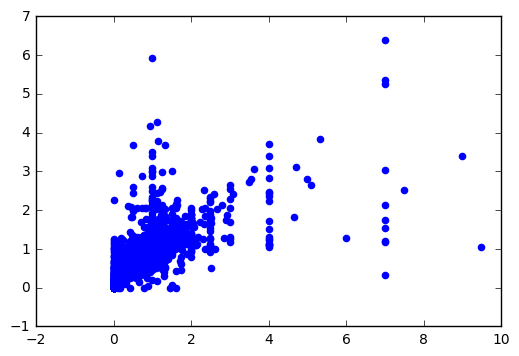

In [85]:
plt.scatter(test_y, rls.predict(test_x), color='blue')
plt.show()

### add n-grams

In [78]:
ngrams = textfeature()

In [79]:
judge_year_index = ngrams.load_data('../datasets/judge_year2index.pkl', format = 'pkl')
ngram_dict = ngrams.load_data('../datasets/grams_dict2002-2016/grams_dict.pkl', format = 'pkl')

bow_feature = ngrams.load_data('../datasets/grams_dict2002-2016/bow_features.pkl', format = 'pkl')
bi_feature = ngrams.load_data('../datasets/grams_dict2002-2016/2grams_feature.pkl', format = 'pkl')

load sucess from ../datasets/judge_year2index.pkl
load sucess from ../datasets/grams_dict2002-2016/grams_dict.pkl
load sucess from ../datasets/grams_dict2002-2016/bow_features.pkl
load sucess from ../datasets/grams_dict2002-2016/2grams_feature.pkl


LOWE, MARY JOHNSON 2006
BRYANT, WILLIAM B. 2003
BRYANT, WILLIAM B. 2005
LOWE, MARY JOHNSON 2006
BRYANT, WILLIAM B. 2003
BRYANT, WILLIAM B. 2005


In [86]:
ngrams.get_train_test(features)
bow_train, bow_test = ngrams.get_vector()
X_train, X_test = ngrams.get_tfidf(bow_train, bow_test)
train_total, test_total = ngrams.combine_data(X_train, X_test)

In [87]:
ols = linear_model.LinearRegression()
ols = ngrams.model_pre(ols, train_total, test_total)

Mean squared error for test data Holger on regression : 0.0000
Mean squared error for train data Holger on regression : 0.0000


(44136, 58)

## Attention model

In [3]:
EMBEDDING_DIM = 100
MAX_SENTS = 100
MAX_SENT_LEN = 100
MAX_NB_WORDS = 500000

In [8]:
data_input = Input(shape=(36+MAX_SENT_LEN,), dtype='int32')
sentence_input = Lambda(lambda x: x[:,36:], output_shape=(MAX_SENT_LEN,))(data_input)
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_dense = TimeDistributed(Dense(200))(l_lstm)
l_att = AttLayer()(l_dense)
sentEncoder = Model(sentence_input, l_att)

review_input = Input(shape=(MAX_SENTS,MAX_SENT_LEN), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
l_dense_sent = TimeDistributed(Dense(200))(l_lstm_sent)
l_att_sent = AttLayer()(l_dense_sent)
preds = Dense(1, activation=None)(l_att_sent)
model = Model(review_input, preds)

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse','mae'])


NameError: name 'embedding_layer' is not defined

In [9]:
data_input

<tf.Tensor 'input_3:0' shape=(?, 136) dtype=int32>

## Visualization